# Naive Bayes and SVM Models Performance

## Packages imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import pprint

import nltk
import sklearn
import re  
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
## For Stemming
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import os
import seaborn as sns
from textblob import TextBlob
from textblob import Word
plt.style.use('classic')
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# nltk.download('wordnet')

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string

from nltk.tokenize import WordPunctTokenizer

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#from sklearn.cluster import KMeans
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer

from nltk import bigrams
import networkx as nx

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#import gensim


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import average_precision_score
from sklearn.model_selection import KFold 
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
from sklearn import model_selection

## Data set reading and Initial EDA

In [2]:
#Importing the movie review dataset from csv file
#path= https://github.com/allloren/text_prediction_application/blob/master/data/m_reviews_dataframe.csv
m_reviews = pd.read_csv("../data/m_reviews_dataframe.csv", sep= ",")

In [3]:
m_reviews.info()
m_reviews.head(-10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    50000 non-null  int64 
 1   reviews  50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


label                                            reviews
0          1  For a movie that gets no respect there sure ar...
1          1  Bizarre horror movie filled with famous faces ...
2          1  A solid, if unremarkable film. Matthau, as Ein...
3          1  It's a strange feeling to sit alone in a theat...
4          1  You probably all already know this by now, but...
...      ...                                                ...
49985      0  Pauline Kael gave this movie a good review but...
49986      0  There must have been a lot of background info ...
49987      0  This is the worst movie I have seen to date. 8...
49988      0  My friends and I rented this movie mistaking i...
49989      0  I am a huge Randolph Scott fan, so I was surpr...

[49990 rows x 2 columns]

Text(0, 0.5, '1= pos, 0- neg')

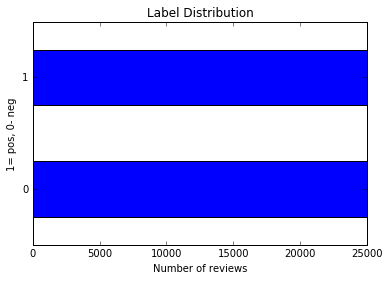

In [4]:
import matplotlib.pyplot as plt
ax = m_reviews['label'].value_counts(sort=False).plot(kind='barh')
ax.set_title ('Label Distribution' )
ax.set_xlabel('Number of reviews')
ax.set_ylabel('1= pos, 0- neg')

In [5]:
#Check any review in the dataset
m_reviews["reviews"][5]

'I saw the movie with two grown children. Although it was not as clever as Shrek, I thought it was rather good. In a movie theatre surrounded by children who were on spring break, there was not a sound so I know the children all liked it. There parents also seemed engaged. The death and apparent death of characters brought about the appropriate gasps and comments. Hopefully people realize this movie was made for kids. As such, it was successful although I liked it too. Personally I liked the Scrat!!'

In [6]:
# cleaning data
# lower case
m_reviews['reviews'] = m_reviews['reviews'].str.lower()
# remove email adress
m_reviews['reviews'] = m_reviews['reviews'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)
# remove IP address
m_reviews['reviews'] = m_reviews['reviews'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)
# remove punctuation and special characters
m_reviews['reviews'] = m_reviews['reviews'].str.replace('[^\w\s]','')

# remove numbers
m_reviews['reviews'] =m_reviews['reviews'].replace('\d', '', regex=True)

# removing stopwords
#stop = stopwords.words('english')

#StopWords definitons
specific_wc = ['Dutcher','dutcher', 'movie', 'movies', 'film', 'would', 'us', 'Mormon', 'mormon','one', 'Paris', 'make', 'audience', 'God', 
               'well', 'Danglard', 'Nini','cristina']
stopw = list(set(stopwords.words('english')))
stopw = stopw + specific_wc

print(stopw[:5])
print(len(stopw))


m_reviews = m_reviews[m_reviews['reviews'].notnull()]
m_reviews['reviews'] = m_reviews['reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stopw))

['at', 'not', "doesn't", 'his', 'weren']
197


In [7]:
print('Cleaned Dataframe')
m_reviews.head(-10)

Cleaned Dataframe


label                                            reviews
0          1  gets respect sure lot memorable quotes listed ...
1          1  bizarre horror filled famous faces stolen rain...
2          1  solid unremarkable matthau einstein wonderful ...
3          1  strange feeling sit alone theater occupied par...
4          1  probably already know additional episodes neve...
...      ...                                                ...
49985      0  pauline kael gave good review terrible outdate...
49986      0  must lot background info left fact girl lizzy ...
49987      0  worst seen date minutes utterly bad actinghalf...
49988      0  friends rented mistaking another skateboarding...
49989      0  huge randolph scott fan surprised disappointed...

[49990 rows x 2 columns]

In [8]:
#Check same review in the dataset after cleaned
m_reviews["reviews"][5]

'saw two grown children although clever shrek thought rather good theatre surrounded children spring break sound know children liked parents also seemed engaged death apparent death characters brought appropriate gasps comments hopefully people realize made kids successful although liked personally liked scrat'

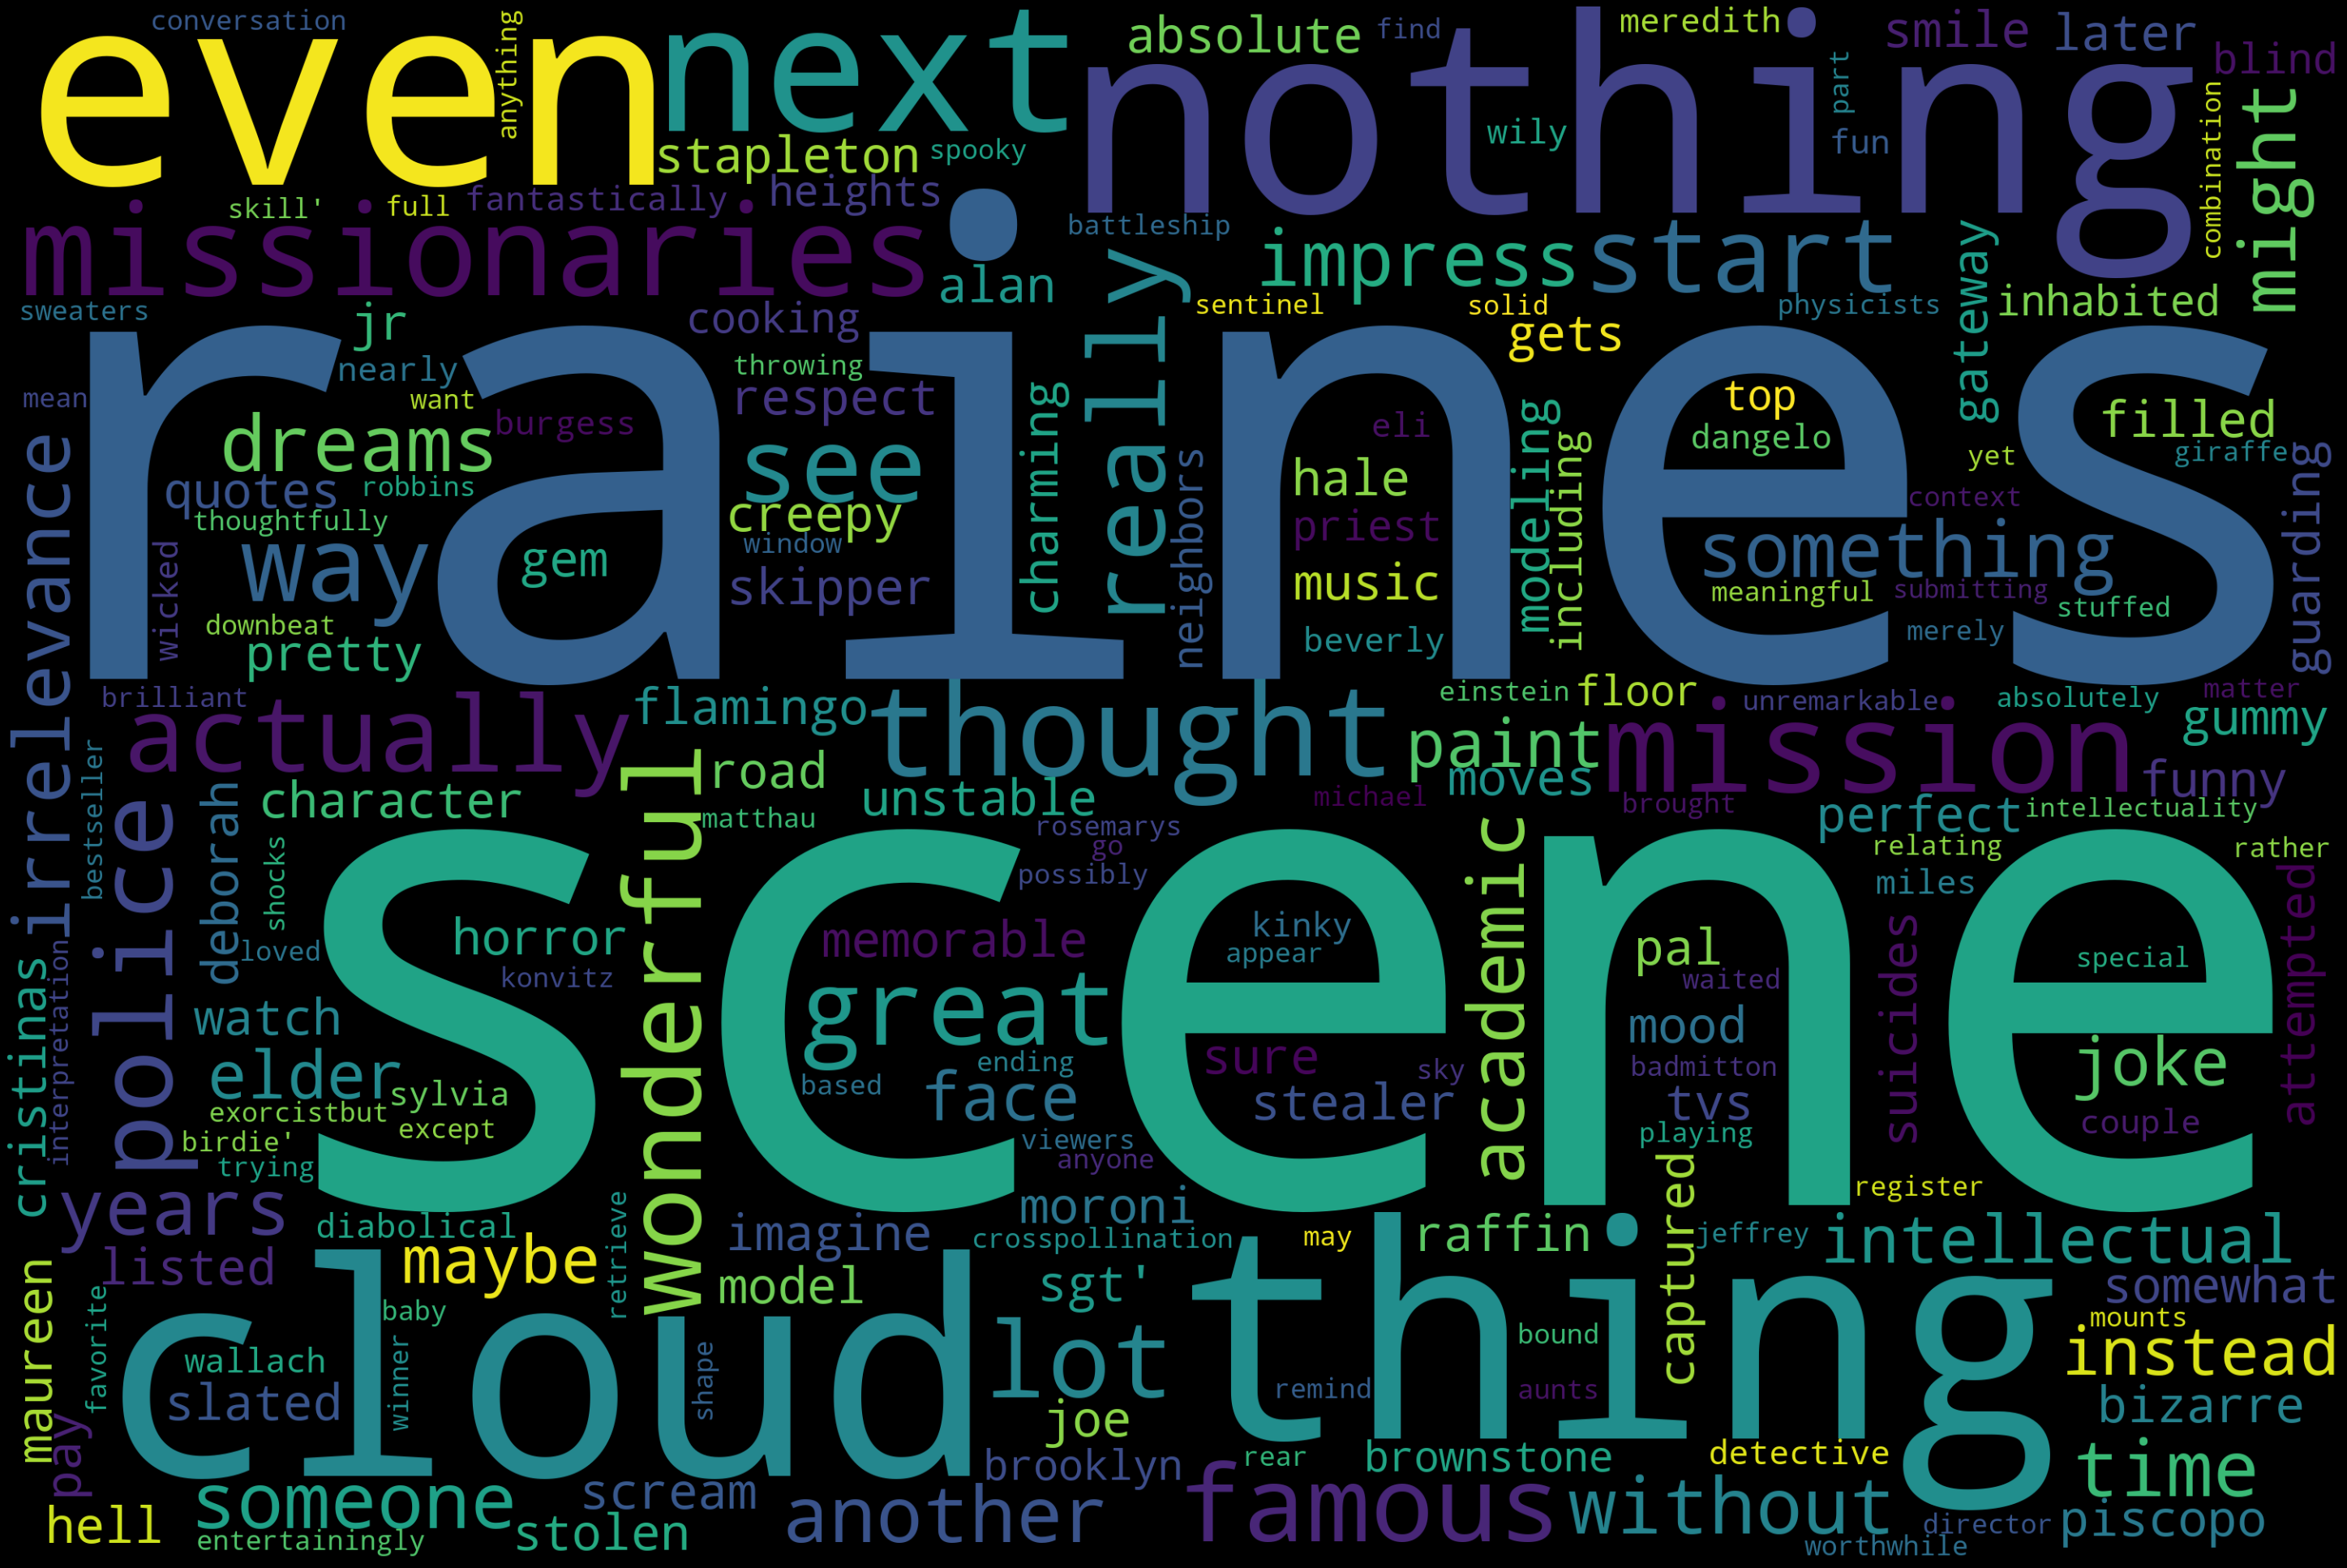

In [13]:
##Wordcloud from all reviews
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = m_reviews.reviews.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

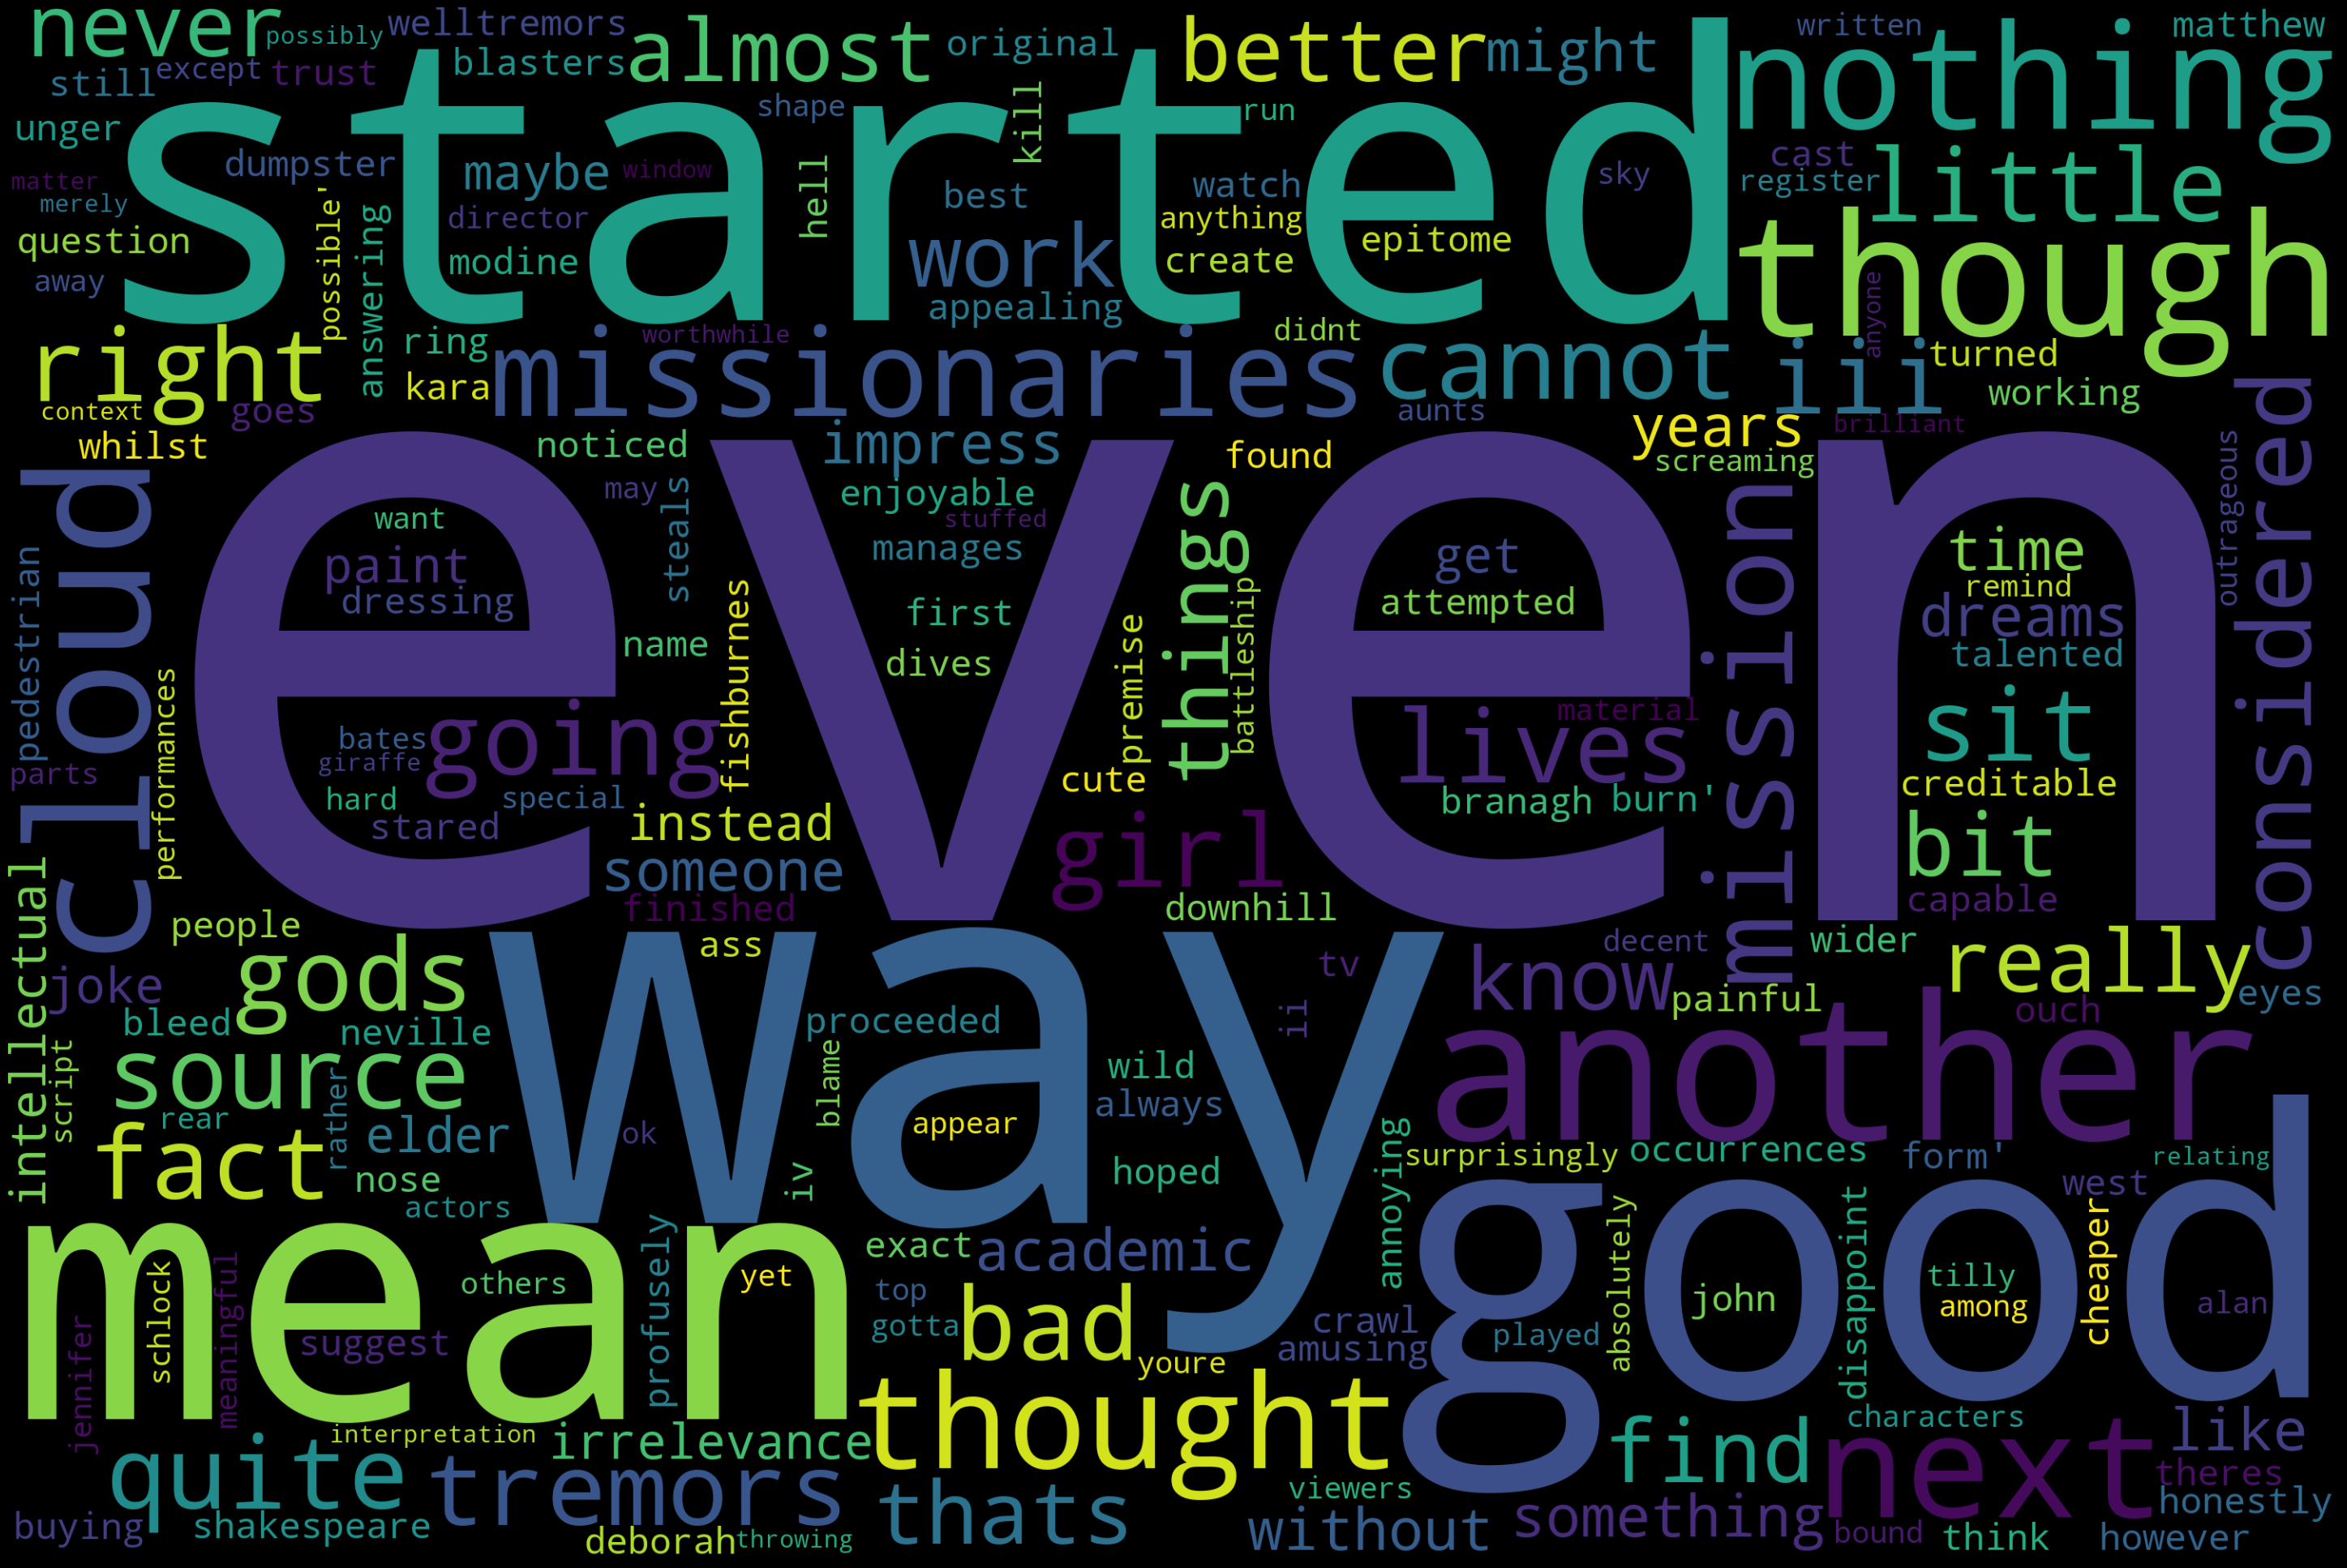

In [14]:
##Wordcloud from negative reviews
#Build data frame with only negative reviews
neg_df = m_reviews[(m_reviews.label == 0)]
#neg_df.head()
text = neg_df.reviews.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stopw).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

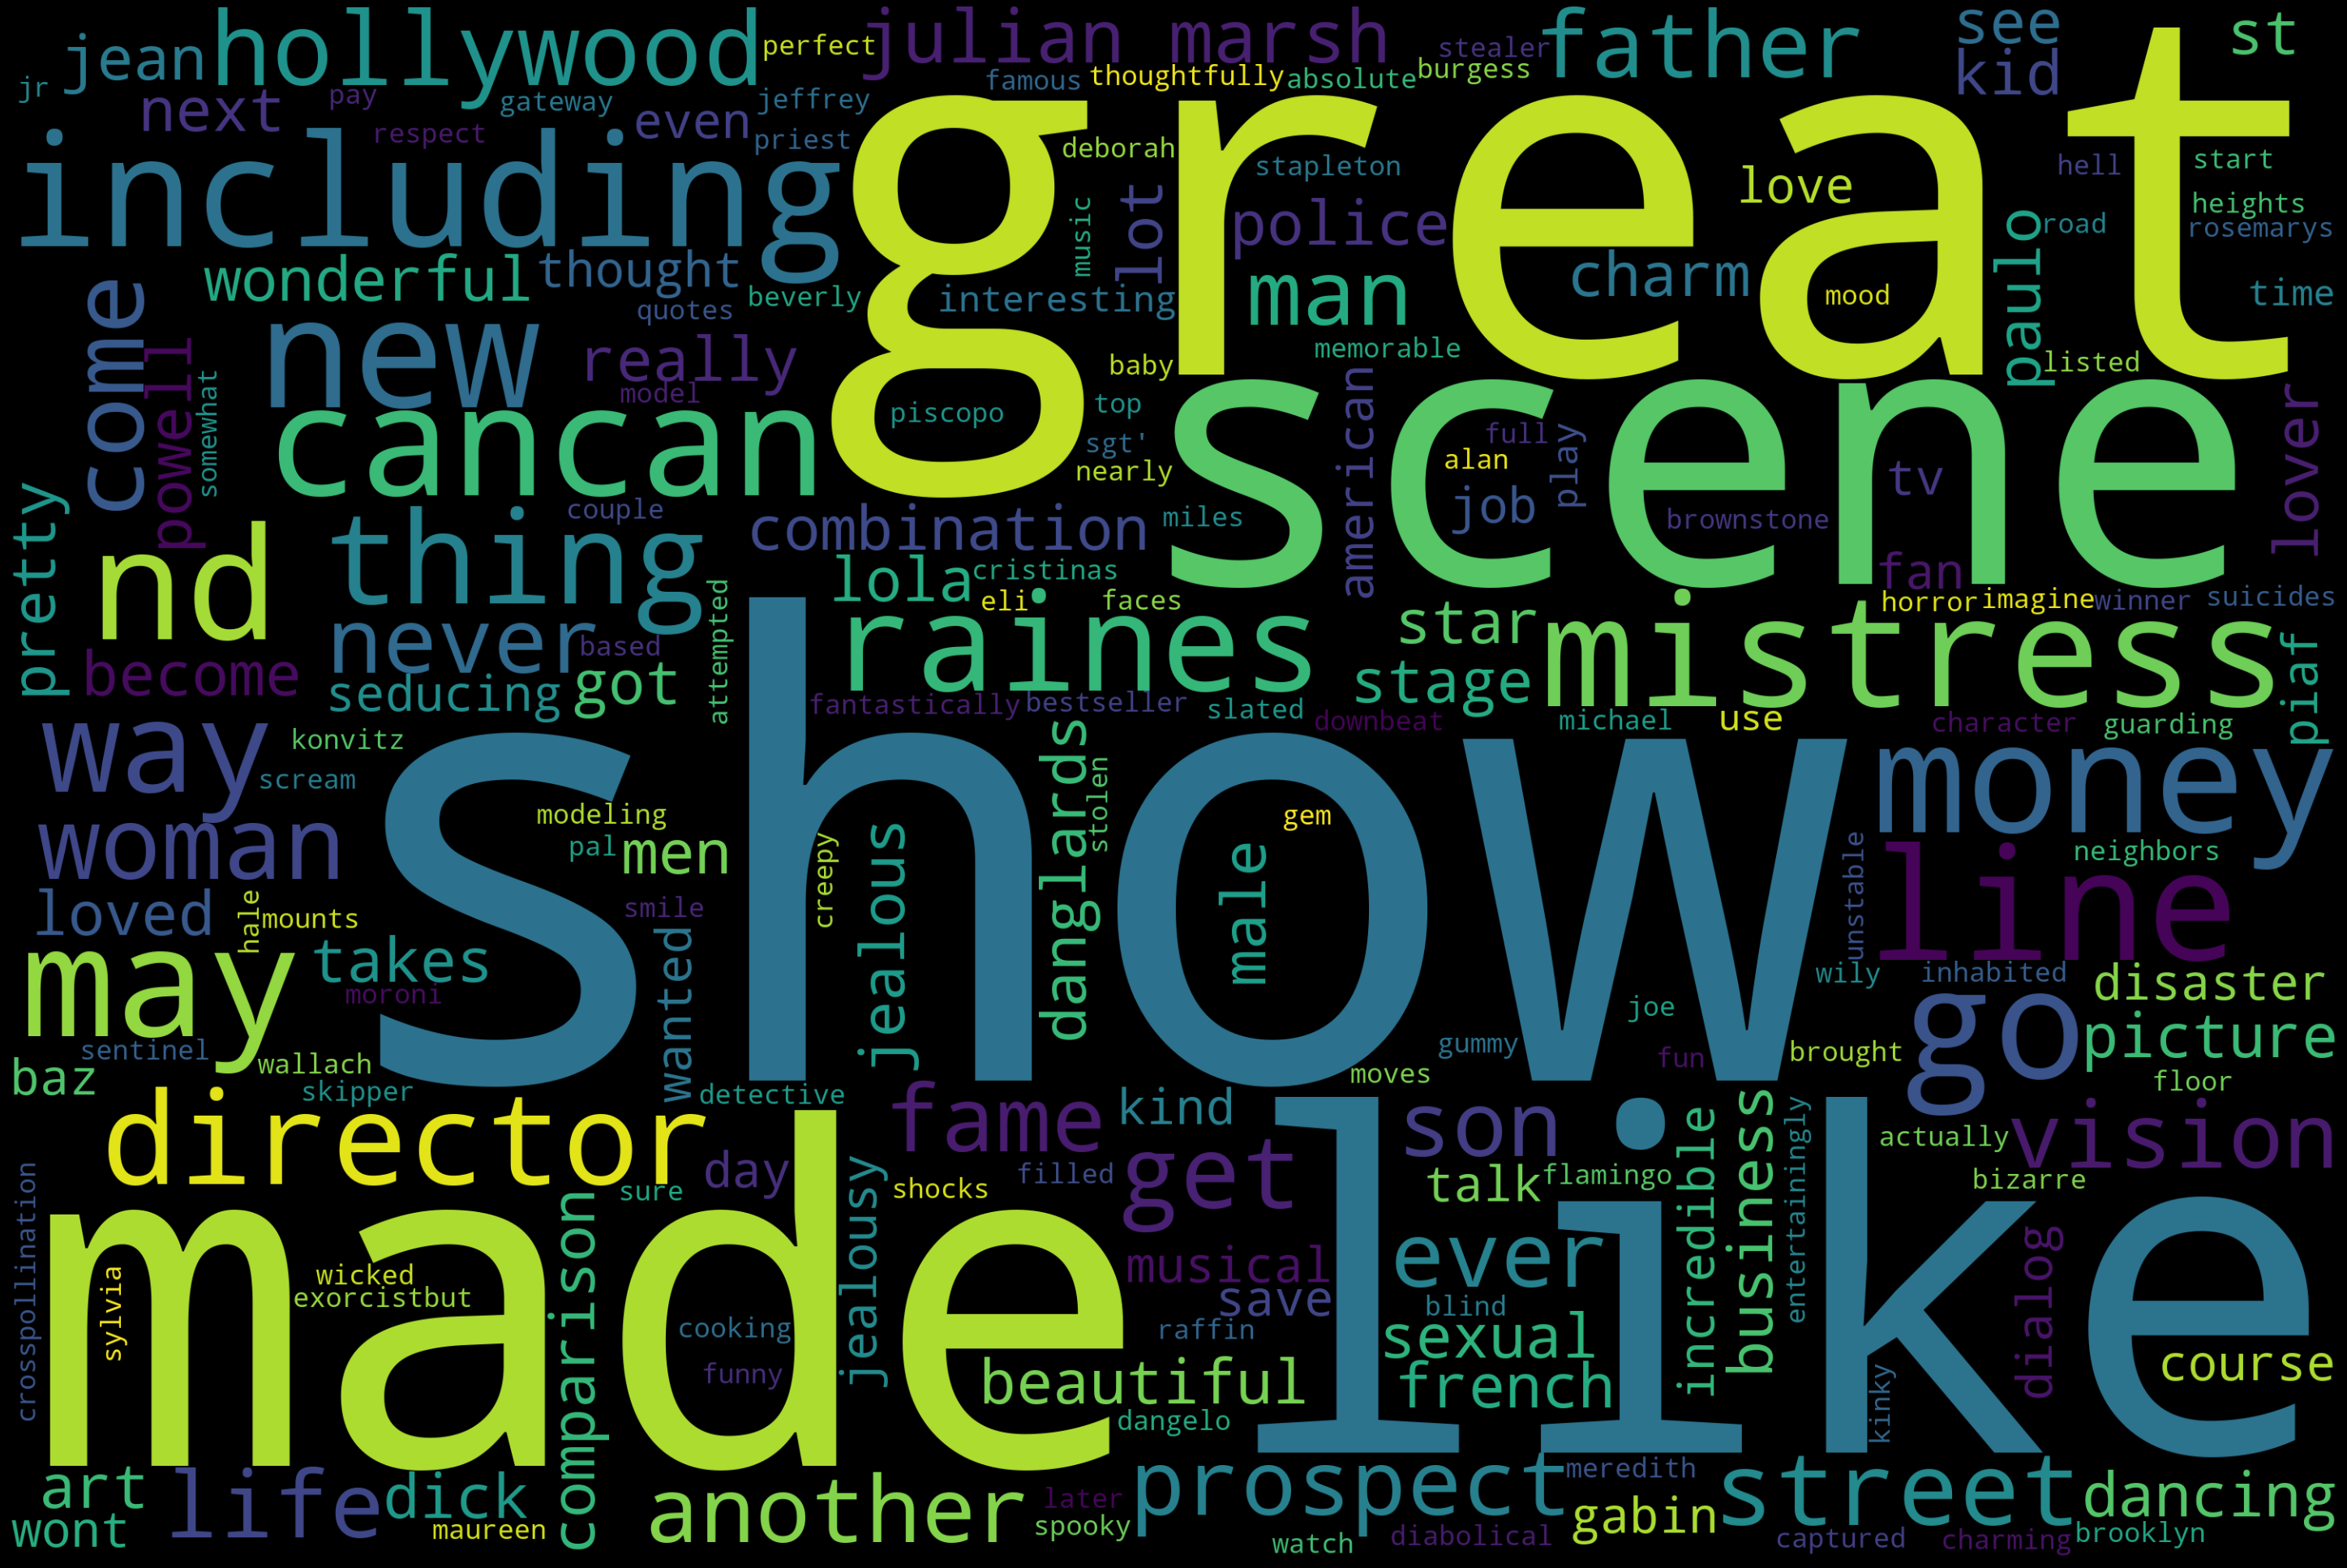

In [15]:
##Wordcloud from positive reviews
#Build data frame with only negative reviews
pos_df = m_reviews[(m_reviews.label == 1)]
#pos_df.head()
text = pos_df.reviews.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stopw).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Distribution of Number of Words used in Reviews


like      39066
good      28913
even      24586
time      23970
really    23014
see       22641
story     22519
much      19109
get       18244
bad       18004
great     17936
also      17859
people    17710
first     17207
dont      16976
dtype: int64

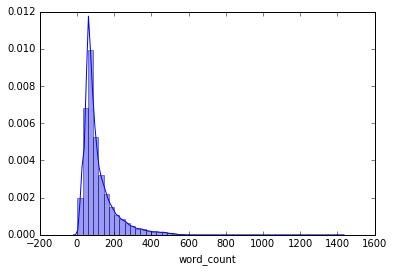

In [9]:
# getting word counts of each review
# after stopword removal
m_reviews['word_count'] = m_reviews['reviews'].apply(lambda x: len(str(x).split(" ")))
#df.head()
print('Distribution of Number of Words used in Reviews')
sns.distplot(m_reviews.word_count)
# most common words
freq = pd.Series(' '.join(m_reviews['reviews']).split()).value_counts()[:15]
freq

In [10]:
# converting words to root words
print('Lemmatizing Data with Common and Rare Words')
m_reviews['reviews'] = m_reviews['reviews'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
m_reviews['reviews'].head(-10)

Lemmatizing Data with Common and Rare Words


0        get respect sure lot memorable quote listed ge...
1        bizarre horror filled famous face stolen raine...
2        solid unremarkable matthau einstein wonderful ...
3        strange feeling sit alone theater occupied par...
4        probably already know additional episode never...
                               ...                        
49985    pauline kael gave good review terrible outdate...
49986    must lot background info left fact girl lizzy ...
49987    worst seen date minute utterly bad actinghalf ...
49988    friend rented mistaking another skateboarding ...
49989    huge randolph scott fan surprised disappointed...
Name: reviews, Length: 49990, dtype: object

In [11]:
# remove rare words

freqrw = pd.Series(' '.join(m_reviews['reviews']).split()).value_counts()[-10:]
freqrw = list(freqrw.index)
m_reviews['reviews'] = m_reviews['reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in freqrw))

# Building Models

## Multinomial Naive Bayes Model

In [12]:
# vectorize MNB
vectMNB = CountVectorizer()
x = vectMNB.fit_transform(m_reviews['reviews'])
y = m_reviews['label']

In [13]:
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=42)#40% for test data
# take a look at the shape of each of these
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(30000, 151320)
(30000,)
(20000, 151320)
(20000,)


In [ ]:
ColumnNamesMNB=vectMNB.get_feature_names()
m_df=pd.DataFrame(x.toarray(),columns=ColumnNamesMNB)
#m_df.append(y)
m_df.head(5)
#m_df.info()

0.85505
[[8683 1233]
 [1666 8418]]


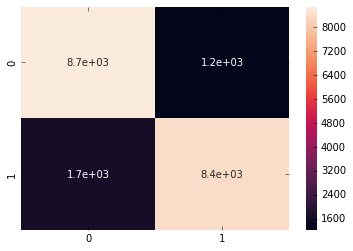

In [14]:
#Multinomial NB Prediction performace
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
y_pred = mnb.predict(x_test)
mnb.score(x_test, y_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
#Plot confusion matrix
cmtrx = confusion_matrix(y_test,y_pred)
sns.heatmap(cmtrx, annot=True)

roc_auc_score


0.9232528697224877

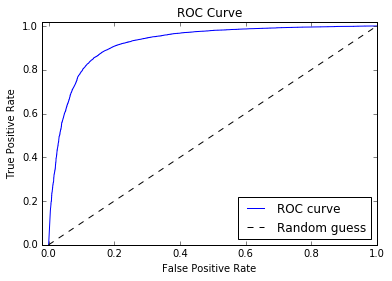

In [16]:
y_pred_prob = mnb.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")
print ('roc_auc_score')
roc_auc_score(y_test, y_pred_prob)

Aveg Precision Score
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      9916
           1       0.87      0.83      0.85     10084

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000



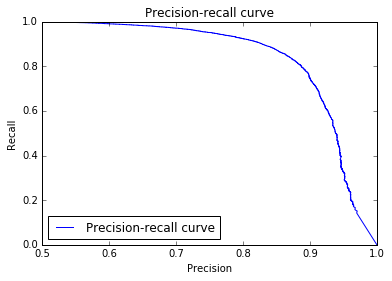

In [17]:
#MNB Performance Metrics
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
# create plot
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('Precision-recall curve')
_ = plt.legend(loc="lower left")
print('Aveg Precision Score')
average_precision_score(y_test, y_pred_prob)
print(classification_report(y_test, y_pred))

## Bernoulli Naive Bayes Model

In [18]:
# vectorize for Bernoulli NB
vectBNB = CountVectorizer(binary=True)
xb = vectBNB.fit_transform(m_reviews['reviews'])

# split into train and test sets
xb_train, xb_test, y_train, y_test = train_test_split(xb, y, test_size=0.40, random_state=42)
# take a look at the shape of each of these
print(xb_train.shape)
print(y_train.shape)
print(xb_test.shape)
print(y_test.shape)

(30000, 151320)
(30000,)
(20000, 151320)
(20000,)


In [18]:
ColumnNamesBNB=vectBNB.get_feature_names()
b_df=pd.DataFrame(xb.toarray(),columns=ColumnNamesBNB)
b_df.head(5)

__  ___  ____  _____  ______  _______  ________  _________  \
0   0    0     0      0       0        0         0          0   
1   0    0     0      0       0        0         0          0   
2   0    0     0      0       0        0         0          0   
3   0    0     0      0       0        0         0          0   
4   0    0     0      0       0        0         0          0   

   _____________________________  ____________________________________  ...  \
0                              0                                     0  ...   
1                              0                                     0  ...   
2                              0                                     0  ...   
3                              0                                     0  ...   
4                              0                                     0  ...   

   überwoman  ünel  ünfaithful  üvegtigris  üzümcü  ýs  þorleifsson  þór  \
0          0     0           0           0       0   0            0    0   
1          0     0           0           0       0   0            0    0   
2          0     0           0           0       0   0            0    0   
3          0     0           0           0       0   0            0    0   
4          0     0           0           0       0   0            0    0   

   יגאל  כרמון  
0     0      0  
1     0      0  
2     0      0  
3     0      0  
4     0      0  

[5 rows x 151320 columns]

0.85
[[8775 1141]
 [1859 8225]]


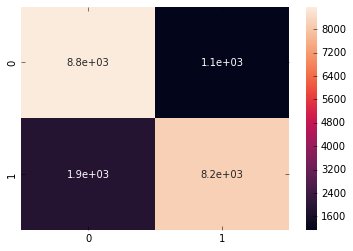

In [19]:
#Bernoulli NB Prediction performace
bnb = BernoulliNB()
bnb.fit(xb_train, y_train)
yb_pred = bnb.predict(xb_test)
bnb.score(xb_test, y_test)
print(accuracy_score(y_test, yb_pred))
print(confusion_matrix(y_test,yb_pred))
#Plot confusion matrix
cmtrx = confusion_matrix(y_test,yb_pred)
sns.heatmap(cmtrx, annot=True)

Bernoulli NB roc_auc_score


0.9254041965201064

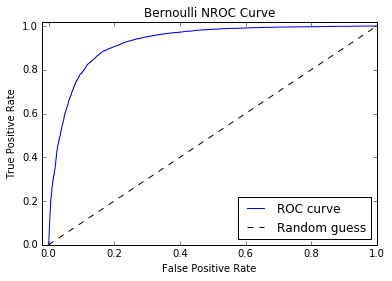

In [22]:
#Roc Score for BNB Model
yb_pred_prob = bnb.predict_proba(xb_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, yb_pred_prob)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Bernoulli NROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")
print ('Bernoulli NB roc_auc_score')
roc_auc_score(y_test, yb_pred_prob)

Bernoulli NB Aveg Precision Score
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      9916
           1       0.88      0.82      0.85     10084

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000



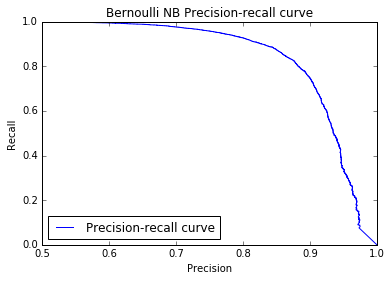

In [23]:
#Performance Metrics for Bernoulli NB Model
precision, recall, thresholds = precision_recall_curve(y_test, yb_pred_prob)
# create plot
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('Bernoulli NB Precision-recall curve')
_ = plt.legend(loc="lower left")
print('Bernoulli NB Aveg Precision Score')
average_precision_score(y_test, yb_pred_prob)
print(classification_report(y_test, yb_pred))

## Multinomial Naive Bayes Model with TfidfVectorizer 

In [24]:
# vectorize MNB wirh Tfidf
vectTfidf = TfidfVectorizer()
xt = vectTfidf.fit_transform(m_reviews['reviews'])

# split into train and test sets
xt_train, xt_test, y_train, y_test = train_test_split(xt, y, test_size=0.40, random_state=42)
# take a look at the shape of each of these
print(xt_train.shape)
print(y_train.shape)
print(xt_test.shape)
print(y_test.shape)

(30000, 151320)
(30000,)
(20000, 151320)
(20000,)


In [23]:
# Tfidf Dataframe
ColumnNamesTfidf=vectTfidf.get_feature_names()
t_df=pd.DataFrame(xt.toarray(),columns=ColumnNamesTfidf)
#t_df.append(y)
t_df.head(5)

__  ___  ____  _____  ______  _______  ________  _________  \
0  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0   
1  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0   
2  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0   
3  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0   
4  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0   

   _____________________________  ____________________________________  ...  \
0                            0.0                                   0.0  ...   
1                            0.0                                   0.0  ...   
2                            0.0                                   0.0  ...   
3                            0.0                                   0.0  ...   
4                            0.0                                   0.0  ...   

   überwoman  ünel  ünfaithful  üvegtigris  üzümcü   ýs  þorleifsson  þór  \
0        0.0   0.0         0.0         0.0     0.0  0.0          0.0  0.0   
1        0.0   0.0         0.0         0.0     0.0  0.0          0.0  0.0   
2        0.0   0.0         0.0         0.0     0.0  0.0          0.0  0.0   
3        0.0   0.0         0.0         0.0     0.0  0.0          0.0  0.0   
4        0.0   0.0         0.0         0.0     0.0  0.0          0.0  0.0   

   יגאל  כרמון  
0   0.0    0.0  
1   0.0    0.0  
2   0.0    0.0  
3   0.0    0.0  
4   0.0    0.0  

[5 rows x 151320 columns]

0.85765
[[8848 1068]
 [1779 8305]]


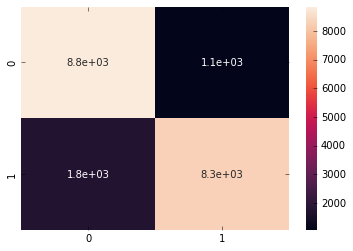

In [25]:
#Tfidf MNB Prediction performace
tnb = MultinomialNB()
tnb.fit(xt_train, y_train)
yt_pred = tnb.predict(xt_test)
tnb.score(xt_test, y_test)
print(accuracy_score(y_test, yt_pred))
print(confusion_matrix(y_test,yt_pred))
#Plot confusion matrix
cmtrx = confusion_matrix(y_test,yt_pred)
sns.heatmap(cmtrx, annot=True)

Tfidf MNB roc_auc_score


0.9368233122529126

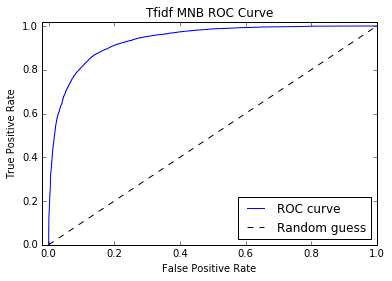

In [26]:
#Roc Score for Tfidf MNB Model
yt_pred_prob = tnb.predict_proba(xt_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, yt_pred_prob)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Tfidf MNB ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")
print ('Tfidf MNB roc_auc_score')
roc_auc_score(y_test, yt_pred_prob)

Tfidf MNB Aveg Precision Score
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      9916
           1       0.89      0.82      0.85     10084

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000



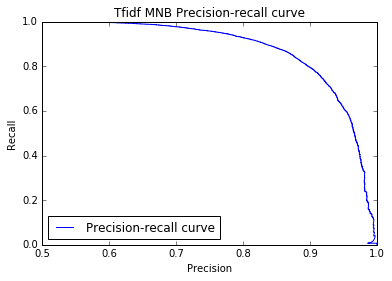

In [27]:
#Performance Metrics Tfidf MNB
precision, recall, thresholds = precision_recall_curve(y_test, yt_pred_prob)
# create plot
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('Tfidf MNB Precision-recall curve')
_ = plt.legend(loc="lower left")
print('Tfidf MNB Aveg Precision Score')
average_precision_score(y_test, yt_pred_prob)
print(classification_report(y_test, yt_pred))

## SVM Lineal Models

0.81255
[[7999 1917]
 [1832 8252]]


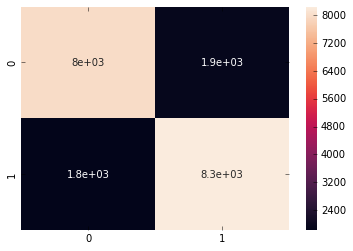

In [28]:
# CountVec SVM Lineal Model with C= .00001 
from sklearn.svm import LinearSVC

svmC00001=LinearSVC(C=.00001)
svmC00001.fit(x_train, y_train)
y_pred = svmC00001.predict(x_test)
svmC00001.score(x_test, y_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
#Plot confusion matrix
cmtrx = confusion_matrix(y_test,y_pred)
sns.heatmap(cmtrx, annot=True)

SVM CountVec roc_auc_score


0.8125010700755045

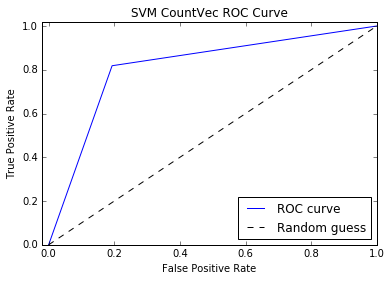

In [29]:
#Roc Score for CountVec SVM lineal Model C=00001

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('SVM CountVec ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")
print ('SVM CountVec roc_auc_score')
roc_auc_score(y_test, y_pred)

SVM CountVec Avg Precision Score
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      9916
           1       0.81      0.82      0.81     10084

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000



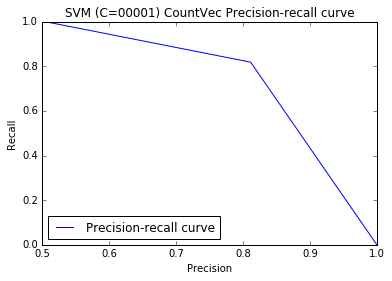

In [30]:
#Performance Metrics for CountVec SVM Lineal Model C=00001 
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# create plot
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('SVM (C=00001) CountVec Precision-recall curve')
_ = plt.legend(loc="lower left")
print('SVM CountVec Avg Precision Score')
average_precision_score(y_test, yt_pred_prob)
print(classification_report(y_test, y_pred))

0.8656
[[8565 1351]
 [1337 8747]]


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



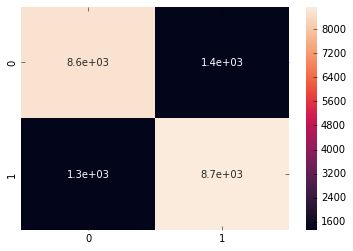

In [31]:
# CountVec SVM Lineal Model with C= 1 

svmC1=LinearSVC(C=1)
svmC1.fit(x_train, y_train)
y_pred = svmC1.predict(x_test)
svmC1.score(x_test, y_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
#Plot confusion matrix
cmtrx = confusion_matrix(y_test,y_pred)
sns.heatmap(cmtrx, annot=True)

SVM CountVec roc_auc_score


0.8655846356518917

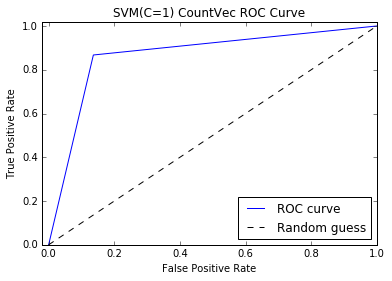

In [32]:
#Roc Score for CountVec SVM lineal Model C=1

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('SVM(C=1) CountVec ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")
print ('SVM CountVec roc_auc_score')
roc_auc_score(y_test, y_pred)

SVM CountVec Avg Precision Score
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      9916
           1       0.87      0.87      0.87     10084

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000



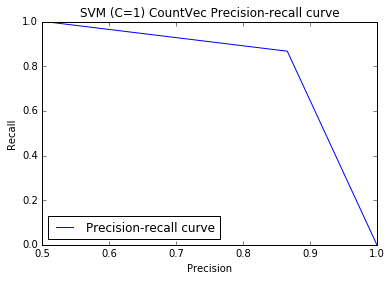

In [33]:
#Performance Metrics for CountVec SVM Lineal Model C=1
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# create plot
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('SVM (C=1) CountVec Precision-recall curve')
_ = plt.legend(loc="lower left")
print('SVM CountVec Avg Precision Score')
average_precision_score(y_test, yt_pred_prob)
print(classification_report(y_test, y_pred))

0.861
[[8542 1374]
 [1406 8678]]


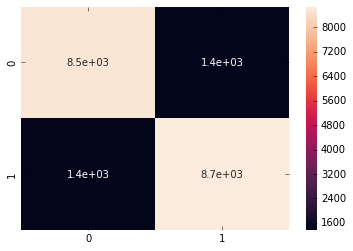

In [34]:
# CountVec SVM Lineal Model with C= 1000 

svmC1000=LinearSVC(C=1000)
svmC1000.fit(x_train, y_train)
y_pred = svmC1000.predict(x_test)
svmC1000.score(x_test, y_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
#Plot confusion matrix
cmtrx = confusion_matrix(y_test,y_pred)
sns.heatmap(cmtrx, annot=True)

SVM (C=10000) CountVec roc_auc_score


0.8610036324163033

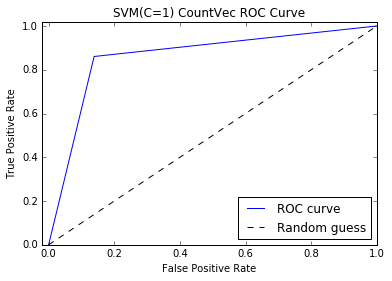

In [35]:
#Roc Score for CountVec SVM lineal Model C=1000

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('SVM(C=1) CountVec ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")
print ('SVM (C=10000) CountVec roc_auc_score')
roc_auc_score(y_test, y_pred)

SVM(C=1000) CountVec Avg Precision Score
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      9916
           1       0.86      0.86      0.86     10084

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000



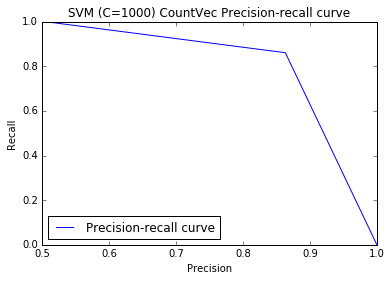

In [36]:
#Performance Metrics for CountVec SVM Lineal Model C=1000
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# create plot
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('SVM (C=1000) CountVec Precision-recall curve')
_ = plt.legend(loc="lower left")
print('SVM(C=1000) CountVec Avg Precision Score')
average_precision_score(y_test, yt_pred_prob)
print(classification_report(y_test, y_pred))

0.4964
[[ 9915     1]
 [10071    13]]


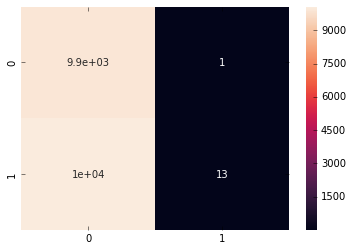

In [37]:
# TfidfVec SVM lineal Model with C= .00001 
svmC00001=LinearSVC(C=.00001)
svmC00001.fit(xt_train, y_train)
yt_pred = svmC00001.predict(xt_test)
svmC00001.score(xt_test, y_test)
print(accuracy_score(y_test, yt_pred))
print(confusion_matrix(y_test,yt_pred))
#Plot confusion matrix
cmtrx = confusion_matrix(y_test,yt_pred)
sns.heatmap(cmtrx, annot=True)

SVM (C=.00001) TfidfVec roc_auc_score


0.5005941619240653

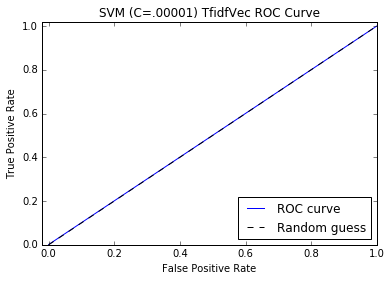

In [38]:
#Roc Score for TfidfVec SVM lineal Model C=.0001 

fpr, tpr, thresholds = roc_curve(y_test, yt_pred)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('SVM (C=.00001) TfidfVec ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")
print ('SVM (C=.00001) TfidfVec roc_auc_score')
roc_auc_score(y_test, yt_pred)

SVM (C=.00001) TfidfVec Aveg Precision Score
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      9916
           1       0.93      0.00      0.00     10084

    accuracy                           0.50     20000
   macro avg       0.71      0.50      0.33     20000
weighted avg       0.71      0.50      0.33     20000



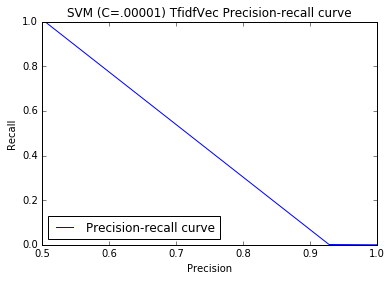

In [39]:
#Performance Metrics for TfidfVec SVM Lineal Model C=.00001
precision, recall, thresholds = precision_recall_curve(y_test, yt_pred)
# create plot
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('SVM (C=.00001) TfidfVec Precision-recall curve')
_ = plt.legend(loc="lower left")
print('SVM (C=.00001) TfidfVec Aveg Precision Score')
average_precision_score(y_test, yt_pred_prob)
print(classification_report(y_test, yt_pred))

0.89355
[[8823 1093]
 [1036 9048]]


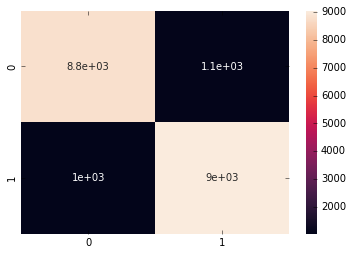

In [40]:
# TfidfVec SVM lineal Model with C= 1 
svmC1=LinearSVC(C=1)
svmC1.fit(xt_train, y_train)
yt_pred = svmC1.predict(xt_test)
svmC1.score(xt_test, y_test)
print(accuracy_score(y_test, yt_pred))
print(confusion_matrix(y_test,yt_pred))
#Plot confusion matrix
cmtrx = confusion_matrix(y_test,yt_pred)
sns.heatmap(cmtrx, annot=True)

SVM (C=1) TfidfVec roc_auc_score


0.8935185466686529

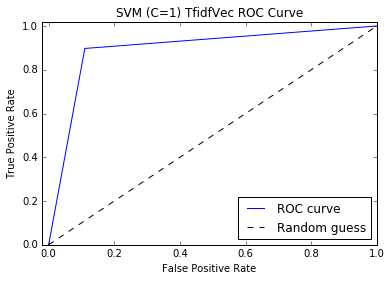

In [41]:
#Roc Score for TfidfVec SVM lineal Model C= 1

fpr, tpr, thresholds = roc_curve(y_test, yt_pred)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('SVM (C=1) TfidfVec ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")
print ('SVM (C=1) TfidfVec roc_auc_score')
roc_auc_score(y_test, yt_pred)

SVM (C=1) TfidfVec Aveg Precision Score
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      9916
           1       0.89      0.90      0.89     10084

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000



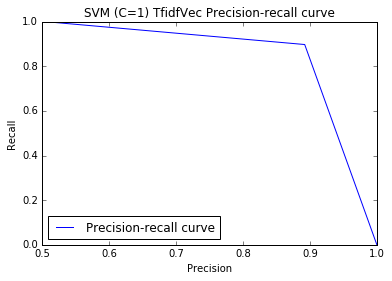

In [42]:
#Performance Metrics for TfidfVec SVM Lineal Model C= 1
precision, recall, thresholds = precision_recall_curve(y_test, yt_pred)
# create plot
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('SVM (C=1) TfidfVec Precision-recall curve')
_ = plt.legend(loc="lower left")
print('SVM (C=1) TfidfVec Aveg Precision Score')
average_precision_score(y_test, yt_pred_prob)
print(classification_report(y_test, yt_pred))

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



0.87305
[[8631 1285]
 [1254 8830]]


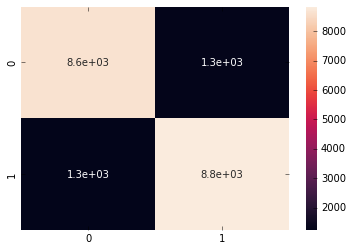

In [43]:
# TfidfVec SVM lineal Model with C= 1000 
svmC1000=LinearSVC(C=1000)
svmC1000.fit(xt_train, y_train)
yt_pred = svmC1000.predict(xt_test)
svmC1000.score(xt_test, y_test)
print(accuracy_score(y_test, yt_pred))
print(confusion_matrix(y_test,yt_pred))
#Plot confusion matrix
cmtrx = confusion_matrix(y_test,yt_pred)
sns.heatmap(cmtrx, annot=True)

SVM (C=1000) TfidfVec roc_auc_score


0.8730280208571517

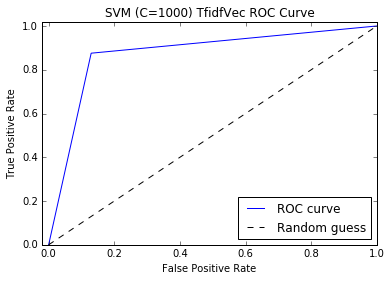

In [44]:
#Roc Score for TfidfVec SVM lineal Model C= 1000

fpr, tpr, thresholds = roc_curve(y_test, yt_pred)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('SVM (C=1000) TfidfVec ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")
print ('SVM (C=1000) TfidfVec roc_auc_score')
roc_auc_score(y_test, yt_pred)

SVM (C=1000) TfidfVec Aveg Precision Score
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      9916
           1       0.87      0.88      0.87     10084

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000



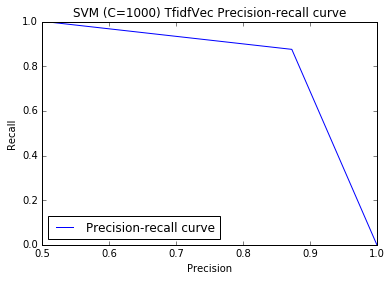

In [45]:
#Performance Metrics for TfidfVec SVM Lineal Model C= 1000
precision, recall, thresholds = precision_recall_curve(y_test, yt_pred)
# create plot
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('SVM (C=1000) TfidfVec Precision-recall curve')
_ = plt.legend(loc="lower left")
print('SVM (C=1000) TfidfVec Aveg Precision Score')
average_precision_score(y_test, yt_pred_prob)
print(classification_report(y_test, yt_pred))

### SVM Non Lienal Models  

0.4958
[[ 9916     0]
 [10084     0]]


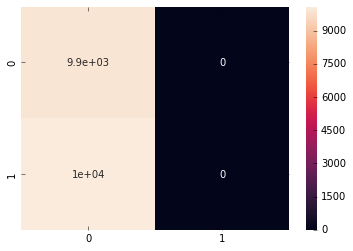

In [72]:
 # SVM RBF Model with C= .00001 
from sklearn.svm import LinearSVC

svmRBFC00001=sklearn.svm.SVC(C=.00001, kernel='rbf', degree=3, gamma="auto")
svmRBFC00001.fit(x_train, y_train)
y_pred = svmRBFC00001.predict(x_test)
svmRBFC00001.score(x_test, y_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
#Plot confusion matrix
cmtrx = confusion_matrix(y_test,y_pred)
sns.heatmap(cmtrx, annot=True)

SVM RBF (C=.00001) roc_auc_score


0.5

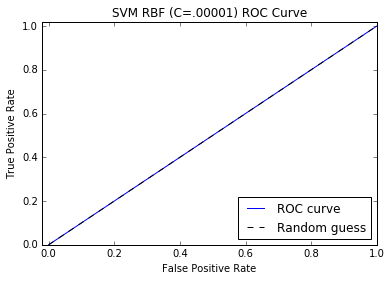

In [73]:
#Roc Score for SVM RBF Model C=00001

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('SVM RBF (C=.00001) ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")
print ('SVM RBF (C=.00001) roc_auc_score')
roc_auc_score(y_test, y_pred)

SVM RBF (C=.00001) Avg Precision Score
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      9916
           1       0.00      0.00      0.00     10084

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000



/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



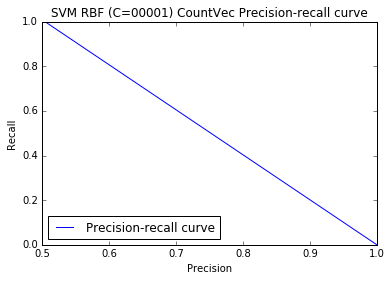

In [74]:
#Performance Metrics for SVM RBF Model C=00001 
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# create plot
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('SVM RBF (C=00001) CountVec Precision-recall curve')
_ = plt.legend(loc="lower left")
print('SVM RBF (C=.00001) Avg Precision Score')
average_precision_score(y_test, yt_pred_prob)
print(classification_report(y_test, y_pred))

0.5821
[[9789  127]
 [8231 1853]]


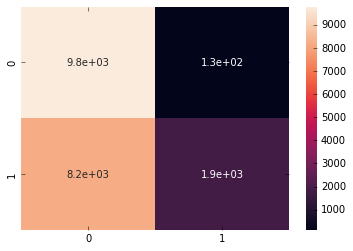

In [33]:
 # SVM RBF Model with C= 1 
from sklearn.svm import LinearSVC

svmRBFC1=sklearn.svm.SVC(C=1, kernel='rbf', degree=3, gamma="auto")
svmRBFC1.fit(x_train, y_train)
y_pred = svmRBFC1.predict(x_test)
svmRBFC1.score(x_test, y_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
#Plot confusion matrix
cmtrx = confusion_matrix(y_test,y_pred)
sns.heatmap(cmtrx, annot=True)

SVM RBF (C=1) roc_auc_score


0.5854744310758567

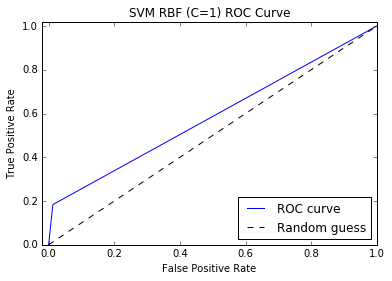

In [34]:
#Roc Score for SVM RBF Model C=1

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('SVM RBF (C=1) ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")
print ('SVM RBF (C=1) roc_auc_score')
roc_auc_score(y_test, y_pred)

SVM RBF (C=1) Avg Precision Score
              precision    recall  f1-score   support

           0       0.54      0.99      0.70      9916
           1       0.94      0.18      0.31     10084

    accuracy                           0.58     20000
   macro avg       0.74      0.59      0.50     20000
weighted avg       0.74      0.58      0.50     20000



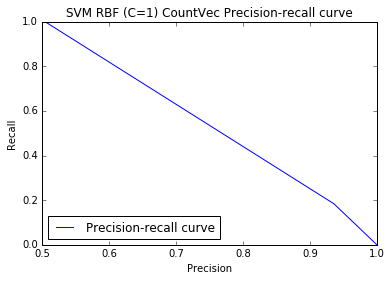

In [35]:
#Performance Metrics for SVM RBF Model C=1 
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# create plot
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('SVM RBF (C=1) CountVec Precision-recall curve')
_ = plt.legend(loc="lower left")
print('SVM RBF (C=1) Avg Precision Score')
average_precision_score(y_test, yt_pred_prob)
print(classification_report(y_test, y_pred))

0.88735
[[8741 1175]
 [1078 9006]]


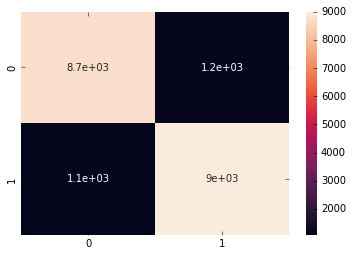

In [39]:
# SVM RBF Model with C= 1000 
from sklearn.svm import LinearSVC

svmRBFC1000=sklearn.svm.SVC(C=1000, kernel='rbf', degree=3, gamma="auto")
svmRBFC1000.fit(x_train, y_train)
y_pred = svmRBFC1000.predict(x_test)
svmRBFC1000.score(x_test, y_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
#Plot confusion matrix
cmtrx = confusion_matrix(y_test,y_pred)
sns.heatmap(cmtrx, annot=True)

SVM RBF (C=1000) roc_auc_score


0.887301307980291

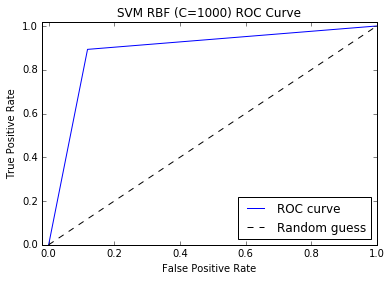

In [40]:
#Roc Score for SVM RBF Model C=1000

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('SVM RBF (C=1000) ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")
print ('SVM RBF (C=1000) roc_auc_score')
roc_auc_score(y_test, y_pred)

SVM RBF (C=1000) Avg Precision Score
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      9916
           1       0.88      0.89      0.89     10084

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000



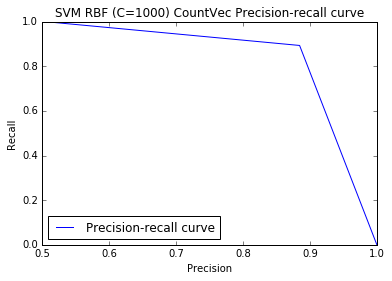

In [41]:
#Performance Metrics for SVM RBF Model C=1000
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# create plot
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('SVM RBF (C=1000) CountVec Precision-recall curve')
_ = plt.legend(loc="lower left")
print('SVM RBF (C=1000) Avg Precision Score')
average_precision_score(y_test, yt_pred_prob)
print(classification_report(y_test, y_pred))

0.4958
[[ 9916     0]
 [10084     0]]


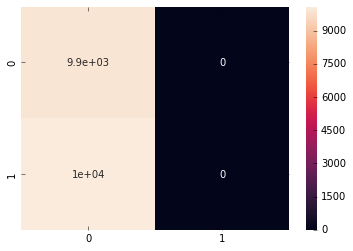

In [75]:
 # SVM POLY Model with C= .00001 

svmPOLYC00001=sklearn.svm.SVC(C=.00001, kernel='poly', degree=3, gamma="auto")
svmPOLYC00001.fit(x_train, y_train)
y_pred = svmPOLYC00001.predict(x_test)
svmPOLYC00001.score(x_test, y_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
#Plot confusion matrix
cmtrx = confusion_matrix(y_test,y_pred)
sns.heatmap(cmtrx, annot=True)

SVM POLY (C=.00001) roc_auc_score


0.5

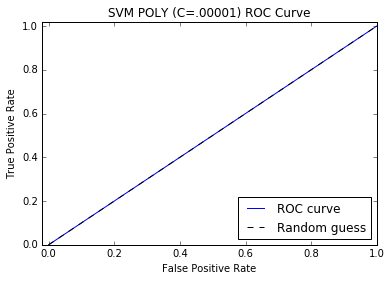

In [76]:
#Roc Score for SVM POLY Model C=00001

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('SVM POLY (C=.00001) ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")
print ('SVM POLY (C=.00001) roc_auc_score')
roc_auc_score(y_test, y_pred)

SVM POY (C=.00001) Avg Precision Score
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      9916
           1       0.00      0.00      0.00     10084

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000



/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



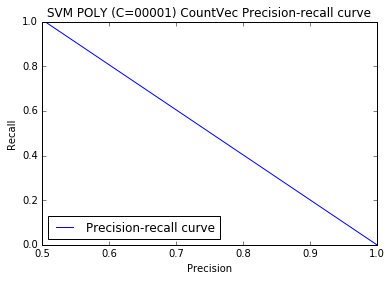

In [77]:
#Performance Metrics for SVM POLY Model C=00001 
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# create plot
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('SVM POLY (C=00001) CountVec Precision-recall curve')
_ = plt.legend(loc="lower left")
print('SVM POLY (C=.00001) Avg Precision Score')
average_precision_score(y_test, yt_pred_prob)
print(classification_report(y_test, y_pred))

0.4958
[[ 9916     0]
 [10084     0]]


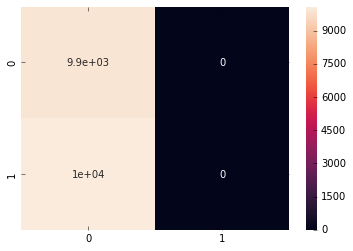

In [27]:
# SVM POLY Model with C= 1

svmPOLYC1=sklearn.svm.SVC(C=1, kernel='poly', degree=3, gamma="auto")
svmPOLYC1.fit(x_train, y_train)
y_pred = svmPOLYC1.predict(x_test)
svmPOLYC1.score(x_test, y_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
#Plot confusion matrix
cmtrx = confusion_matrix(y_test,y_pred)
sns.heatmap(cmtrx, annot=True)

SVM POLY (C=1) roc_auc_score


0.5

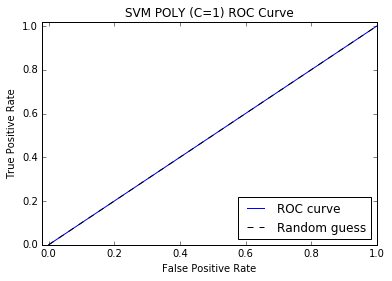

In [28]:
#Roc Score for SVM POLY Model C=1

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('SVM POLY (C=1) ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")
print ('SVM POLY (C=1) roc_auc_score')
roc_auc_score(y_test, y_pred)

SVM POLY (C=1) Avg Precision Score
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      9916
           1       0.00      0.00      0.00     10084

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000



/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



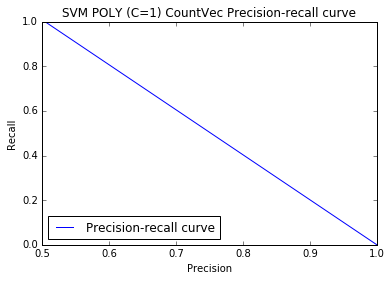

In [29]:
#Performance Metrics for SVM POLY Model C=1
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# create plot
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('SVM POLY (C=1) CountVec Precision-recall curve')
_ = plt.legend(loc="lower left")
print('SVM POLY (C=1) Avg Precision Score')
average_precision_score(y_test, yt_pred_prob)
print(classification_report(y_test, y_pred))

0.4958
[[ 9916     0]
 [10084     0]]


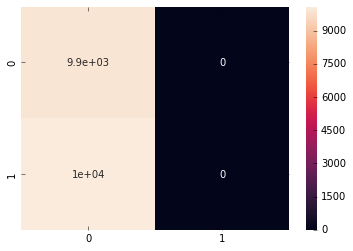

In [43]:
 # SVM POLY Model with C= 1000

svmPOLYC1000=sklearn.svm.SVC(C=1000, kernel='poly', degree=3, gamma="auto")
svmPOLYC1000.fit(x_train, y_train)
y_pred = svmPOLYC1000.predict(x_test)
svmPOLYC1000.score(x_test, y_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
#Plot confusion matrix
cmtrx = confusion_matrix(y_test,y_pred)
sns.heatmap(cmtrx, annot=True)

SVM POLY (C=1000) roc_auc_score


0.5

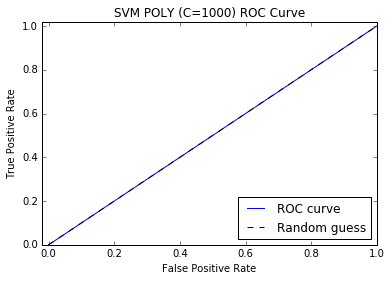

In [44]:
#Roc Score for SVM POLY Model C=1000

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('SVM POLY (C=1000) ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")
print ('SVM POLY (C=1000) roc_auc_score')
roc_auc_score(y_test, y_pred)

SVM POLY (C=1000) Avg Precision Score
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      9916
           1       0.00      0.00      0.00     10084

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000



/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



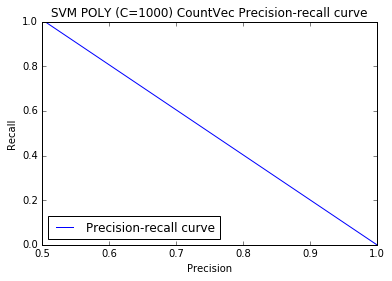

In [45]:
#Performance Metrics for SVM POLY Model C=1000
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# create plot
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('SVM POLY (C=1000) CountVec Precision-recall curve')
_ = plt.legend(loc="lower left")
print('SVM POLY (C=1000) Avg Precision Score')
average_precision_score(y_test, yt_pred_prob)
print(classification_report(y_test, y_pred))

In [ ]:
# SVM POLY Model with C= 100000

svmPOLYC10000=sklearn.svm.SVC(C=10000, kernel='poly', degree=3, gamma="auto")
svmPOLYC10000.fit(x_train, y_train)
y_pred = svmPOLYC10000.predict(x_test)
svmPOLYC10000.score(x_test, y_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
#Plot confusion matrix
cmtrx = confusion_matrix(y_test,y_pred)
sns.heatmap(cmtrx, annot=True)

### Top 10 most indicative words for positive category and negative category 

In [ ]:
def rev_important_features(vectorizer,classifier, n):
    class_labels = classifier.classes_
    feature_names = vectTfidf.get_feature_names()
    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names), reverse = True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names), reverse = True)[:n]
    print('Top 10 words fot negative category')
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)
    print("-----------------------------------------")
    print("Top 10 words for positive category")
    for coef, feat in topn_class2:
        print(class_labels[1], coef, feat)

In [66]:
# Multinomial Naive Bayes Best Model
rev_important_features(vectTfidf,tnb, n=10)

Most indicative words per sentiment for Naive Bayes Best Model
Top 10 words fot negative category
0 380.56662401789896 bad
0 377.3667723788568 like
0 306.54662971509697 even
0 293.19673065385257 good
0 272.354339523965 time
0 271.3886993739593 character
0 263.5884931705409 really
0 251.80896426286782 get
0 247.83935479645626 dont
0 234.91232133273903 scene
-----------------------------------------
Top 10 words for positive category
1 320.72539260961673 great
1 288.8672891400651 good
1 285.882499113288 like
1 281.0982509615198 story
1 272.7174125421261 time
1 257.3593726406835 see
1 253.6048791895829 character
1 240.7555447519329 show
1 231.37795488076725 love
1 230.94691298471128 really


In [67]:
#Top indicative words for most positive and most negative for SVM best model
feature_ranks = sorted(zip(svmC1.coef_[0], vectTfidf.get_feature_names()))
print ("Most indicative words per sentiment for SVM Best Model")
## get the 10 features that are best indicators of negative sentiment (they are at the bottom of the ranked list)
very_negative_10 = feature_ranks[:10]
print("Top 10 words fot negative category")
for i in range(0, len(very_negative_10)):
    print(very_negative_10[i])
print()

feature_ranks = sorted(zip(svmC1.coef_[0], vectTfidf.get_feature_names()))
print("-----------------------------------------")
## get the 10 features that are best indicators of very negative sentiment (they are at the bottom of the ranked list)
very_positive_10 = feature_ranks[-10:]
print("Top 10 words for positive category")
for i in range(0, len(very_positive_10)):
    print(very_positive_10[i])
print() 

Most indicative words per sentiment for SVM Best Model
Top 10 words fot negative category
(-5.529706631769508, 'worst')
(-4.720147176639024, 'waste')
(-4.500898059261947, 'awful')
(-3.3452668493933526, 'bad')
(-3.2900745535979046, 'disappointment')
(-3.2445167176633825, 'poorly')
(-3.2250257960031843, 'disappointing')
(-3.1187647523437034, 'boring')
(-3.1149575863540786, 'fails')
(-2.966859267953971, 'dull')

-----------------------------------------
Top 10 words for positive category
(2.4251535258045864, 'gem')
(2.465669973162768, 'superb')
(2.521786198815889, 'loved')
(2.5679209538197645, 'perfect')
(2.6142617129210204, 'amazing')
(2.659983599032767, 'highly')
(2.7812599892358527, 'today')
(2.8125267275048214, 'favorite')
(3.0717317408366513, 'great')
(3.2422887917410246, 'excellent')

